In [6]:
import torch
import data as Data
import model as Model
import argparse
import logging
import core.logger as Logger
import core.metrics as Metrics
from tensorboardX import SummaryWriter
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tqdm import tqdm
import glob
import natsort
import multiprocessing
import seaborn as sns
import pandas as pd

In [2]:
def gmsm(img1, img2, data_range=255, constant = 0.001): #gradient magnitude similarity mean
    #https://arxiv.org/ftp/arxiv/papers/1308/1308.3052.pdf
    grad = np.gradient(img1)
    d_img1 = np.sqrt(grad[0]*grad[0]+grad[1]*grad[1])
    grad = np.gradient(img2)
    d_img2 = np.sqrt(grad[0]*grad[0]+grad[1]*grad[1])
    
    d_img1 = d_img1/255
    d_img2 = d_img2/255

    gms = ((2*d_img1*d_img2)+constant)/((d_img1*d_img1 + d_img2*d_img2)+constant)
    gmsm = np.mean(gms)
    return gmsm

def g_ssim(img1, img2, data_range=255): #gradient-structural similarity metric
    grad = np.gradient(img1)
    d_img1 = np.sqrt(grad[0]*grad[0]+grad[1]*grad[1])
    grad = np.gradient(img2)
    d_img2 = np.sqrt(grad[0]*grad[0]+grad[1]*grad[1])
    return ssim(d_img1, d_img2, data_range=data_range)

In [ ]:
#ignore
savedir = 'test_dataset_results'
readdir = 'misc/85_256_outputs'

for img_path in tqdm(sorted(glob.glob(readdir + '/*'))):
    break
    img_name = os.path.splitext(os.path.split(img_path)[1])[0].replace('test_', '').replace('_r0','')
    img  = np.array(Image.open(img_path))
    hr   = Image.fromarray(img[:,:256])
    lr   = Image.fromarray(img[:,256:512])
    fake = Image.fromarray(img[:,512:768])
    sr   = Image.fromarray(img[:,768:])
    hr.save(savedir+'/hr/hr_'+img_name+'.png')
    lr.save(savedir+'/lr/lr_'+img_name+'.png')
    fake.save(savedir+'/fake/fake_'+img_name+'.png')
    sr.save(savedir+'/ddpm/ddpm_'+img_name+'.png')

 89%|████████▉ | 12471/14000 [15:12<01:56, 13.13it/s]

In [9]:
#ignore
for i,img_path in tqdm(enumerate(natsort.natsorted(glob.glob('test_dataset_results/ddpm/*')))):
    break
    basepath = os.path.split(img_path)[0]
    img_number = int(os.path.splitext(os.path.split(img_path)[1])[0].replace('ddpm_',''))%3500
    img_string = '{:05}'.format(img_number)
    
    if i//3500 < 1:
        midpath = '/C0004065_1_'
    elif i//3500 < 2:
        midpath = '/C0004214_1_'
    elif i//3500 < 3:
        midpath = '/C0004236_1_'
    elif i//3500 < 4:
        midpath = '/C0004238_1_'
    newpath = basepath + midpath + img_string + '.png'
#     print(img_path)
#     print(newpath)
    os.rename(img_path, newpath)

14000it [00:00, 71990.92it/s]


In [3]:
#RUN THIS CELL WITH THE CORRECT INPUT AND OUTPUT DIRECTORIES TO YOUR IMAGES TO CALCULATE IQAs (IMAGE QUALITY ASSESSMENT)


# count = 0
count = 3500

fake_ssim = [0,0,0,0]
fake_psnr = [0,0,0,0]
fake_gmsm = [0,0,0,0]
fake_g_ssim = [0,0,0,0]

srcnn_ssim = [0,0,0,0]
srcnn_psnr = [0,0,0,0]
srcnn_gmsm = [0,0,0,0]
srcnn_g_ssim = [0,0,0,0]

srgan_ssim = [0,0,0,0]
srgan_psnr = [0,0,0,0]
srgan_gmsm = [0,0,0,0]
srgan_g_ssim = [0,0,0,0]

srresnet_ssim = [0,0,0,0]
srresnet_psnr = [0,0,0,0]
srresnet_gmsm = [0,0,0,0]
srresnet_g_ssim = [0,0,0,0]

ddpm_ssim = [0,0,0,0]
ddpm_psnr = [0,0,0,0]
ddpm_gmsm = [0,0,0,0]
ddpm_g_ssim = [0,0,0,0]

# fake_ssim_list = []
# srcnn_ssim_list = []
# srgan_ssim_list = []
# srresnet_ssim_list = []
# ddpm_ssim_list = []

# fake_psnr_list = []
# srcnn_psnr_list = []
# srgan_psnr_list = []
# srresnet_psnr_list = []
# ddpm_psnr_list = []

for i, path in tqdm(enumerate(natsort.natsorted(glob.glob('test_dataset_results/hr/*')))):
#     if i >= 3500:
#         break
    scan_index = i//3500
    

#     count += 1
    
    
    #DEFINE IMAGE INPUT PATHS HERE
    path = os.path.split(path)[1]
    hr = np.array(Image.open('test_dataset_results/hr/' + path))[:255,:255,0]
    fake = np.array(Image.open('test_dataset_results/fake/' + path))[:255,:255,0]
    srcnn = np.array(Image.open('test_dataset_results/srcnn/' + path))[:,:,0]
    srgan = np.array(Image.open('test_dataset_results/srgan/' + path))[:,:,0]
    srresnet = np.array(Image.open('test_dataset_results/srresnet/' + path))[:,:,0]
    ddpm = np.array(Image.open('test_dataset_results/ddpm/' + path))[:255,:255,0]
    
    fake_ssim[scan_index] += ssim(hr, fake, data_range=255)
    srcnn_ssim[scan_index] += ssim(hr, srcnn, data_range=255)
    srgan_ssim[scan_index] += ssim(hr, srgan, data_range=255)
    srresnet_ssim[scan_index] += ssim(hr, srresnet, data_range=255)
    ddpm_ssim[scan_index] += ssim(hr, ddpm, data_range=255)
    
    fake_psnr[scan_index] += psnr(hr, fake, data_range=255)
    srcnn_psnr[scan_index] += psnr(hr, srcnn, data_range=255)
    srgan_psnr[scan_index] += psnr(hr, srgan, data_range=255)
    srresnet_psnr[scan_index] += psnr(hr, srresnet, data_range=255)
    ddpm_psnr[scan_index] += psnr(hr, ddpm, data_range=255)
    
    fake_gmsm[scan_index] += gmsm(hr, fake, data_range=255)
    srcnn_gmsm[scan_index] += gmsm(hr, srcnn, data_range=255)
    srgan_gmsm[scan_index] += gmsm(hr, srgan, data_range=255)
    srresnet_gmsm[scan_index] += gmsm(hr, srresnet, data_range=255)
    ddpm_gmsm[scan_index] += gmsm(hr, ddpm, data_range=255)
    
    fake_g_ssim[scan_index] += g_ssim(hr, fake, data_range=255)
    srcnn_g_ssim[scan_index] += g_ssim(hr, srcnn, data_range=255)
    srgan_g_ssim[scan_index] += g_ssim(hr, srgan, data_range=255)
    srresnet_g_ssim[scan_index] += g_ssim(hr, srresnet, data_range=255)
    ddpm_g_ssim[scan_index] += g_ssim(hr, ddpm, data_range=255)
    
#     fake_ssim_list.append(ssim(hr, fake, data_range=255))
#     srcnn_ssim_list.append(ssim(hr, srcnn, data_range=255))
#     srgan_ssim_list.append(ssim(hr, srgan, data_range=255))
#     srresnet_ssim_list.append(ssim(hr, srresnet, data_range=255))
#     ddpm_ssim_list.append(ssim(hr, ddpm, data_range=255))
    
#     fake_psnr_list.append(psnr(hr, fake, data_range=255))
#     srcnn_psnr_list.append(psnr(hr, srcnn, data_range=255))
#     srgan_psnr_list.append(psnr(hr, srgan, data_range=255))
#     srresnet_psnr_list.append(psnr(hr, srresnet, data_range=255))
#     ddpm_psnr_list.append(psnr(hr, ddpm, data_range=255))
    
fake_ssim = fake_ssim/count
srcnn_ssim = srcnn_ssim/count
srgan_ssim = srgan_ssim/count
srresnet_ssim = srresnet_ssim/count
ddpm_ssim = ddpm_ssim/count

fake_psnr = fake_psnr/count
srcnn_psnr = srcnn_psnr/count
srgan_psnr = srgan_psnr/count
srresnet_psnr = srresnet_psnr/count
ddpm_psnr = ddpm_psnr/count

fake_g_ssim = fake_g_ssim/count
srcnn_g_ssim = srcnn_g_ssim/count
srgan_g_ssim = srgan_g_ssim/count
srresnet_g_ssim = srresnet_g_ssim/count
ddpm_g_ssim = ddpm_g_ssim/count

fake_gmsm = fake_gmsm/count
srcnn_gmsm = srcnn_gmsm/count
srgan_gmsm = srgan_gmsm/count
srresnet_gmsm = srresnet_gmsm/count
ddpm_gmsm = ddpm_gmsm/count

14000it [20:42, 11.27it/s]


TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [4]:
#RUN THIS CELL WITH TO GET AVERAGE SCORES (AS OPPOSED TO TOTAL)

ssims = np.array([fake_ssim, srcnn_ssim, srresnet_ssim, srgan_ssim, ddpm_ssim])/count
psnrs = np.array([fake_psnr, srcnn_psnr, srresnet_psnr, srgan_psnr, ddpm_psnr])/count
gmsms = np.array([fake_gmsm, srcnn_gmsm, srresnet_gmsm, srgan_gmsm, ddpm_gmsm])/count
g_ssims = np.array([fake_g_ssim, srcnn_g_ssim, srresnet_g_ssim, srgan_g_ssim, ddpm_g_ssim])/count

In [26]:
import pickle

# with open('test_dataset_results/ssims.pickle', 'wb') as f:
#     pickle.dump(ssims, f)
# with open('test_dataset_results/psnrs.pickle', 'wb') as f:
#     pickle.dump(psnrs, f)
# with open('test_dataset_results/gmsms.pickle', 'wb') as f:
#     pickle.dump(gmsms, f)
# with open('test_dataset_results/g_ssims.pickle', 'wb') as f:
#     pickle.dump(g_ssims, f)

with open('test_dataset_results/ssims.pickle', 'rb') as f:
    ssims = pickle.load(f)
with open('test_dataset_results/psnrs.pickle', 'rb') as f:
    psnrs = pickle.load(f)
with open('test_dataset_results/gmsms.pickle', 'rb') as f:
    gmsms = pickle.load(f)
with open('test_dataset_results/g_ssims.pickle', 'rb') as f:
    g_ssims = pickle.load(f)

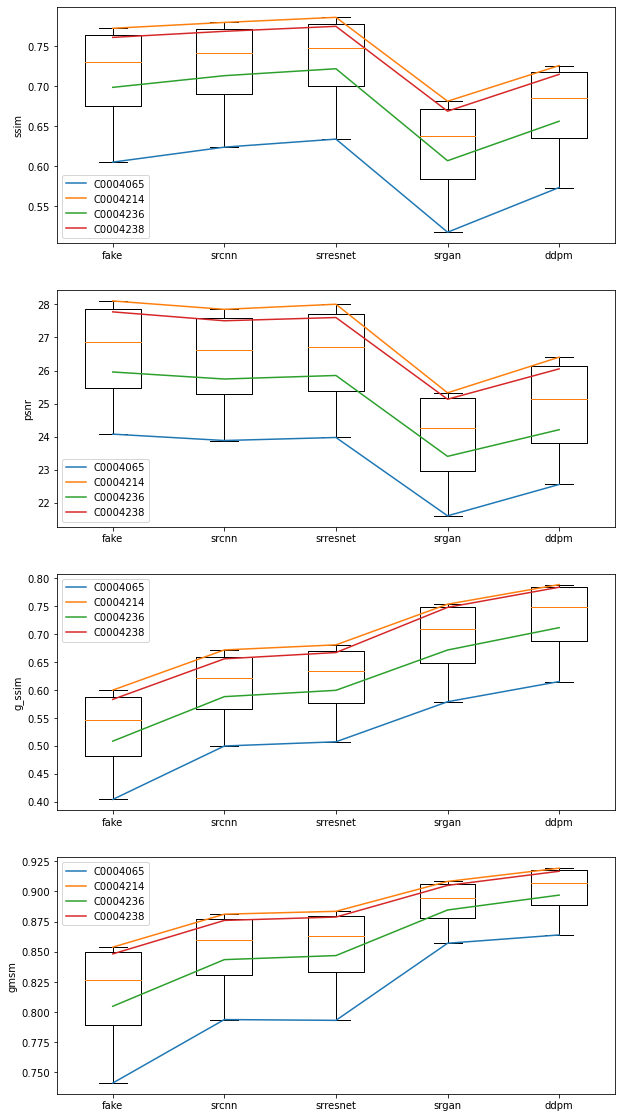

In [4]:
#RUN THIS CELL TO PLOT AS BOXPLOTS AND FOR INDIVIDUAL IMAGES

labels = ['fake','srcnn','srresnet','srgan','ddpm']

fig, axs = plt.subplots(4,1, figsize=(10,20))
axs[0].boxplot(np.transpose(ssims), labels=labels, positions=[0,1,2,3,4])
axs[0].plot(ssims, label=['C0004065','C0004214','C0004236','C0004238'])
axs[0].set_ylabel('ssim')
axs[0].legend()

axs[1].boxplot(np.transpose(psnrs), labels=labels, positions=[0,1,2,3,4])
axs[1].plot(psnrs, label=['C0004065','C0004214','C0004236','C0004238'])
axs[1].set_ylabel('psnr')
axs[1].legend()

axs[2].boxplot(np.transpose(g_ssims), labels=labels, positions=[0,1,2,3,4])
axs[2].plot(g_ssims, label=['C0004065','C0004214','C0004236','C0004238'])
axs[2].set_ylabel('g_ssim')
axs[2].legend()

axs[3].boxplot(np.transpose(gmsms), labels=labels, positions=[0,1,2,3,4])
axs[3].plot(gmsms, label=['C0004065','C0004214','C0004236','C0004238'])
axs[3].set_ylabel('gmsm')
axs[3].legend()

# plt.savefig('test_dataset_results/metric_boxplots.svg', format='svg')
plt.savefig('test_dataset_results/metric_boxplots.png', format='png')
plt.show()

In [ ]:
print('psnr')
print(fake_psnr)
print(srcnn_psnr)
print(srgan_psnr)
print(srresnet_psnr)
print(ddpm_psnr)
print('\n')

print('ssim')
print(fake_ssim)
print(srcnn_ssim)
print(srgan_ssim)
print(srresnet_ssim)
print(ddpm_ssim)
print('\n')

print('gmsm')
print(fake_gmsm)
print(srcnn_gmsm)
print(srgan_gmsm)
print(srresnet_gmsm)
print(ddpm_gmsm)
print('\n')

print('g_ssim')
print(fake_g_ssim)
print(srcnn_g_ssim)
print(srgan_g_ssim)
print(srresnet_g_ssim)
print(ddpm_g_ssim)
print('\n')

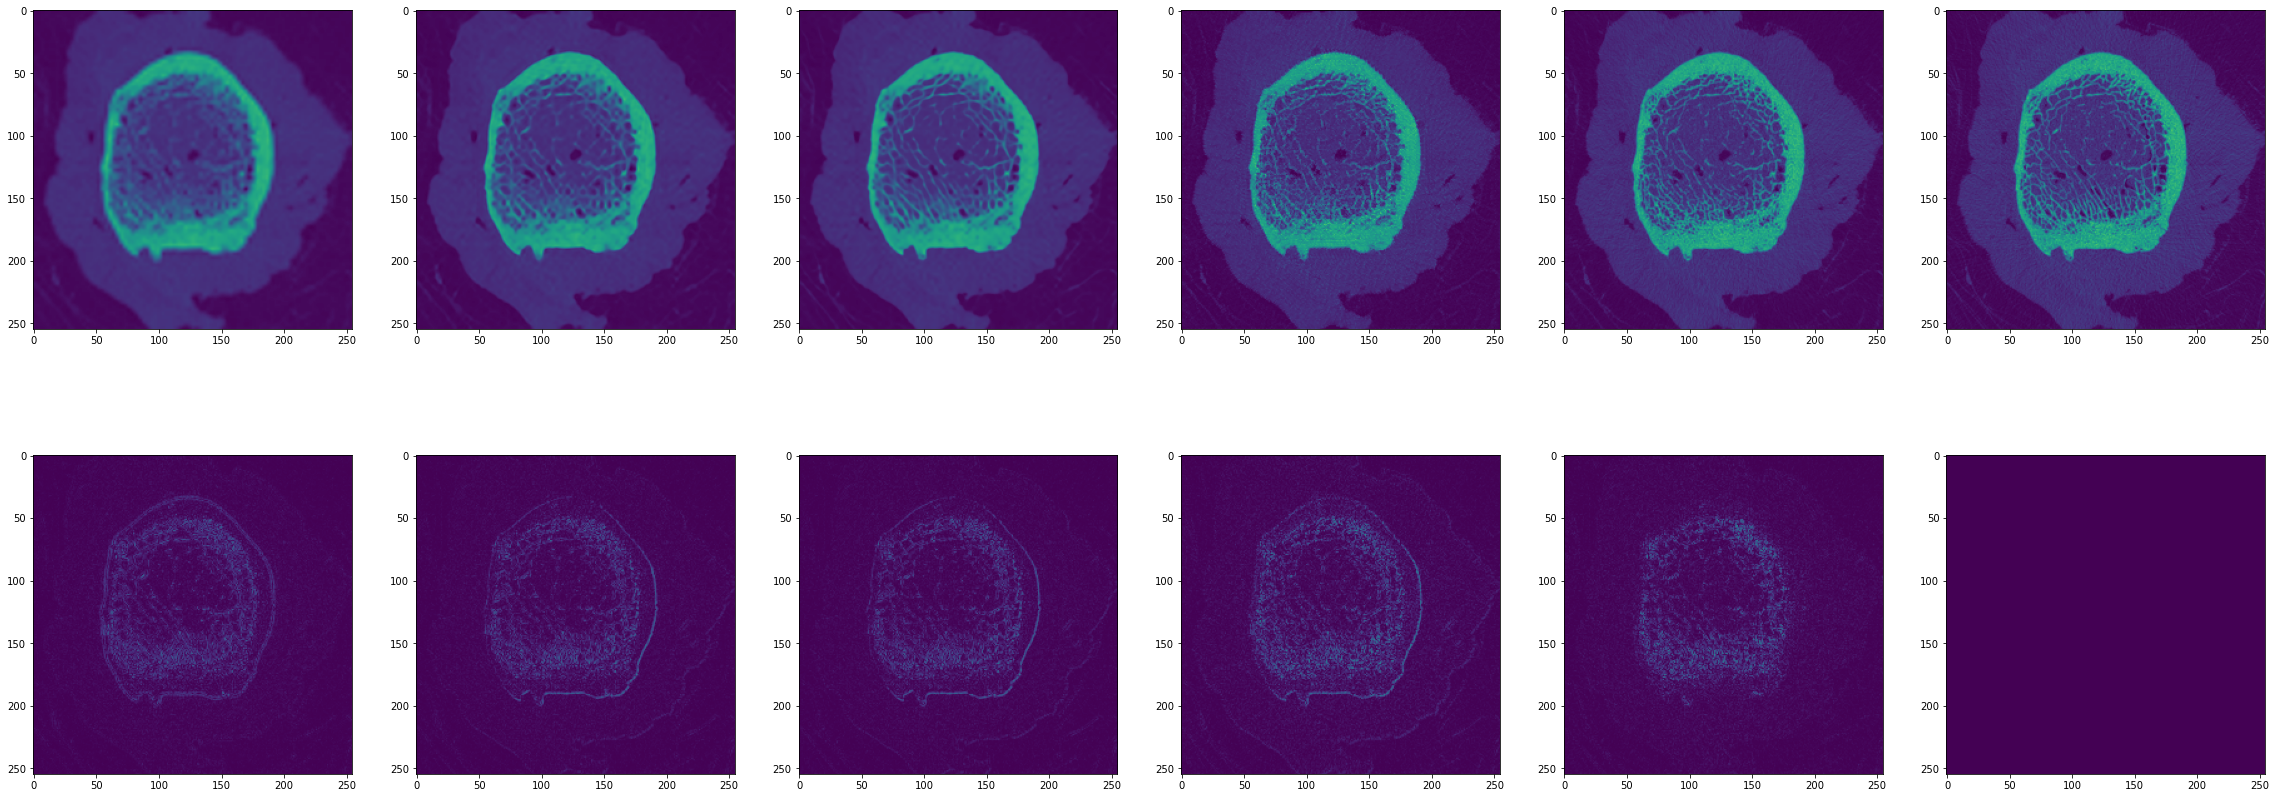

In [60]:
import random
filelist = natsort.natsorted(glob.glob('test_dataset_results/hr/*'))
path = filelist[int(random.random()*len(filelist))] 

path = os.path.split(path)[1]
hr = np.array(Image.open('test_dataset_results/hr/' + path))[:255,:255,0]
fake = np.array(Image.open('test_dataset_results/fake/' + path))[:255,:255,0]
srcnn = np.array(Image.open('test_dataset_results/srcnn/' + path))[:,:,0]
srgan = np.array(Image.open('test_dataset_results/srgan/' + path))[:,:,0]
srresnet = np.array(Image.open('test_dataset_results/srresnet/' + path))[:,:,0]
ddpm = np.array(Image.open('test_dataset_results/ddpm/' + path))[:255,:255,0]



fig, axs = plt.subplots(2,6, figsize=(40,15))

axs[0,0].imshow(fake, vmin=0, vmax = 255)
axs[0,1].imshow(srcnn, vmin=0, vmax = 255)
axs[0,2].imshow(srresnet, vmin=0, vmax = 255)
axs[0,3].imshow(srgan, vmin=0, vmax = 255)
axs[0,4].imshow(ddpm, vmin=0, vmax = 255)
axs[0,5].imshow(hr, vmin=0, vmax = 255)
axs[1,0].imshow(np.abs(hr.astype(np.int8)-fake.astype(np.int8)), vmin=0, vmax = 255)
axs[1,1].imshow(np.abs(hr.astype(np.int8)-srcnn.astype(np.int8)), vmin=0, vmax = 255)
axs[1,2].imshow(np.abs(hr.astype(np.int8)-srresnet.astype(np.int8)), vmin=0, vmax = 255)
axs[1,3].imshow(np.abs(hr.astype(np.int8)-srgan.astype(np.int8)), vmin=0, vmax = 255)
axs[1,4].imshow(np.abs(hr.astype(np.int8)-ddpm.astype(np.int8)), vmin=0, vmax = 255)
axs[1,5].imshow(np.abs(hr.astype(np.int8)-hr.astype(np.int8)), vmin=0, vmax = 255)

44.22951503238533
3.533942699760253
90.94641279346867
8.801055303153953
85.93165889240123
7.951597845350406
95.92314632037463
7.850081028689393
77.01460900374681
4.545067366159594


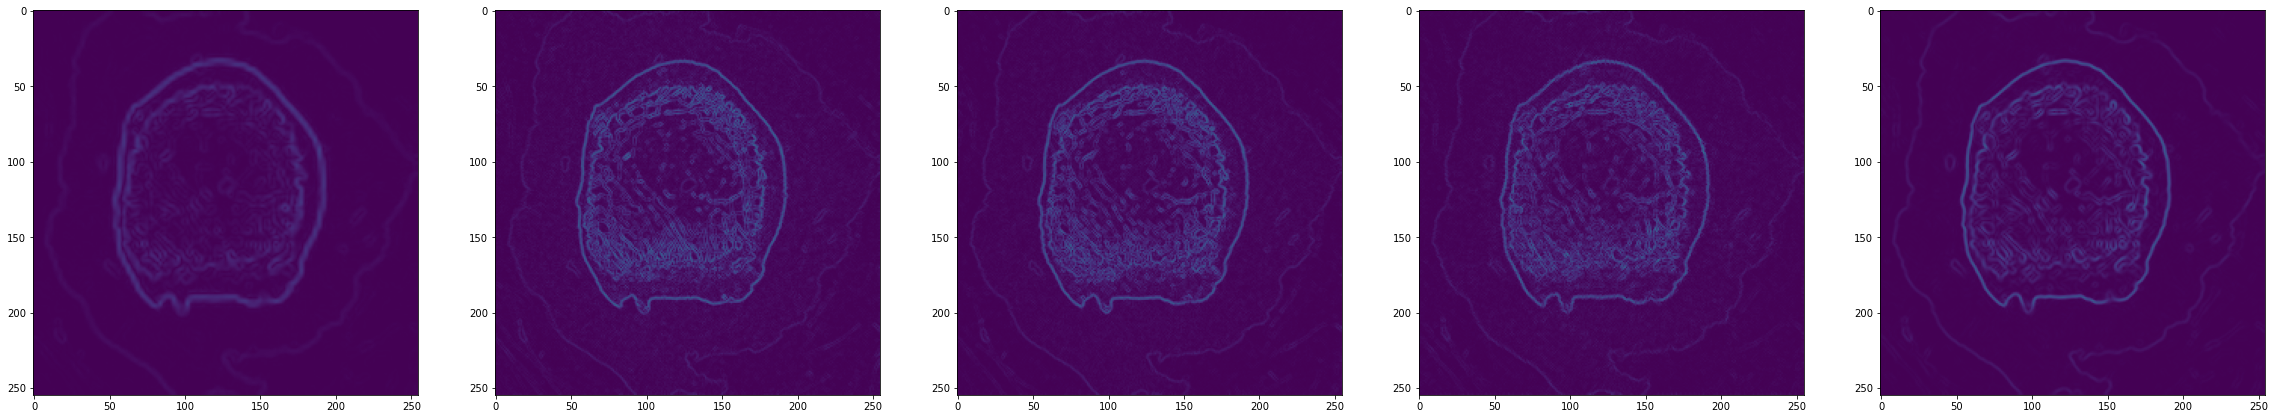

In [66]:
fig, axs = plt.subplots(1,5, figsize=(40,15))

grads = np.gradient(fake)
gradim = np.sqrt(grads[0]*grads[0]+grads[1]*grads[1])
axs[0].imshow(gradim, vmin=0, vmax = 255)
print(np.max(gradim))
print(np.mean(gradim))

grads = np.gradient(hr)
gradim = np.sqrt(grads[0]*grads[0]+grads[1]*grads[1])
axs[1].imshow(gradim, vmin=0, vmax = 255)
print(np.max(gradim))
print(np.mean(gradim))

grads = np.gradient(ddpm)
gradim = np.sqrt(grads[0]*grads[0]+grads[1]*grads[1])
axs[2].imshow(gradim, vmin=0, vmax = 255)
print(np.max(gradim))
print(np.mean(gradim))

grads = np.gradient(srgan)
gradim = np.sqrt(grads[0]*grads[0]+grads[1]*grads[1])
axs[3].imshow(gradim, vmin=0, vmax = 255)
print(np.max(gradim))
print(np.mean(gradim))

grads = np.gradient(srcnn)
gradim = np.sqrt(grads[0]*grads[0]+grads[1]*grads[1])
axs[4].imshow(gradim, vmin=0, vmax = 255)
print(np.max(gradim))
print(np.mean(gradim))